In [2]:
from util.utils import get_som_labeled_img, check_ocr_box, get_caption_model_processor, get_yolo_model
import torch
from ultralytics import YOLO
from PIL import Image
device = 'cuda'
model_path='weights/icon_detect/model.pt'

som_model = get_yolo_model(model_path)

som_model.to(device)
print('model to {}'.format(device))

model to cuda


In [3]:
# two choices for caption model: fine-tuned blip2 or florence2
import importlib
# import util.utils
# importlib.reload(utils)
from util.utils import get_som_labeled_img, check_ocr_box, get_caption_model_processor, get_yolo_model
caption_model_processor = get_caption_model_processor(model_name="florence2", model_name_or_path="weights/icon_caption_florence", device=device)



Florence2LanguageForConditionalGeneration has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


In [4]:
som_model.device, type(som_model) 

(device(type='cuda', index=0), ultralytics.models.yolo.model.YOLO)

In [17]:
# reload utils
import importlib
import utils
importlib.reload(utils)
# from utils import get_som_labeled_img, check_ocr_box, get_caption_model_processor, get_yolo_model

image_path = 'imgs/google_page.png'
# image_path = 'imgs/windows_home.png'
# image_path = 'imgs/windows_multitab.png'
# image_path = 'imgs/omni3.jpg'
# image_path = 'imgs/ios.png'
# image_path = 'imgs/word.png'
# image_path = 'imgs/excel2.png'
image_path = "/home/han/Documents/repos/ShowUI/datasets/ScreenSpot/images/" + "pc_3f805781-f2fe-45dc-8bc5-e62d12f1c359.png"

image = Image.open(image_path)
image_rgb = image.convert('RGB')
print('image size:', image.size)

box_overlay_ratio = max(image.size) / 3200
draw_bbox_config = {
    'text_scale': 0.8 * box_overlay_ratio,
    'text_thickness': max(int(2 * box_overlay_ratio), 1),
    'text_padding': max(int(3 * box_overlay_ratio), 1),
    'thickness': max(int(3 * box_overlay_ratio), 1),
}
BOX_TRESHOLD = 0.2

import time
start = time.time()
ocr_bbox_rslt, is_goal_filtered = check_ocr_box(image_path, display_img = False, output_bb_format='xyxy', goal_filtering=None, easyocr_args={'paragraph': False, 'text_threshold':0.9}, use_paddleocr=True)
text, ocr_bbox = ocr_bbox_rslt
cur_time_ocr = time.time() 

dino_labled_img, label_coordinates, parsed_content_list = get_som_labeled_img(image_path, som_model, BOX_TRESHOLD = BOX_TRESHOLD, output_coord_in_ratio=True, ocr_bbox=ocr_bbox,draw_bbox_config=draw_bbox_config, caption_model_processor=caption_model_processor, ocr_text=text,use_local_semantics=True, iou_threshold=0.7, scale_img=False, batch_size=128)
cur_time_caption = time.time() 


image size: (1710, 1558)

0: 1184x1280 95 icons, 27.7ms
Speed: 12.3ms preprocess, 27.7ms inference, 0.6ms postprocess per image at shape (1, 3, 1184, 1280)
len(filtered_boxes): 121 65
time to get parsed content: 0.1586449146270752


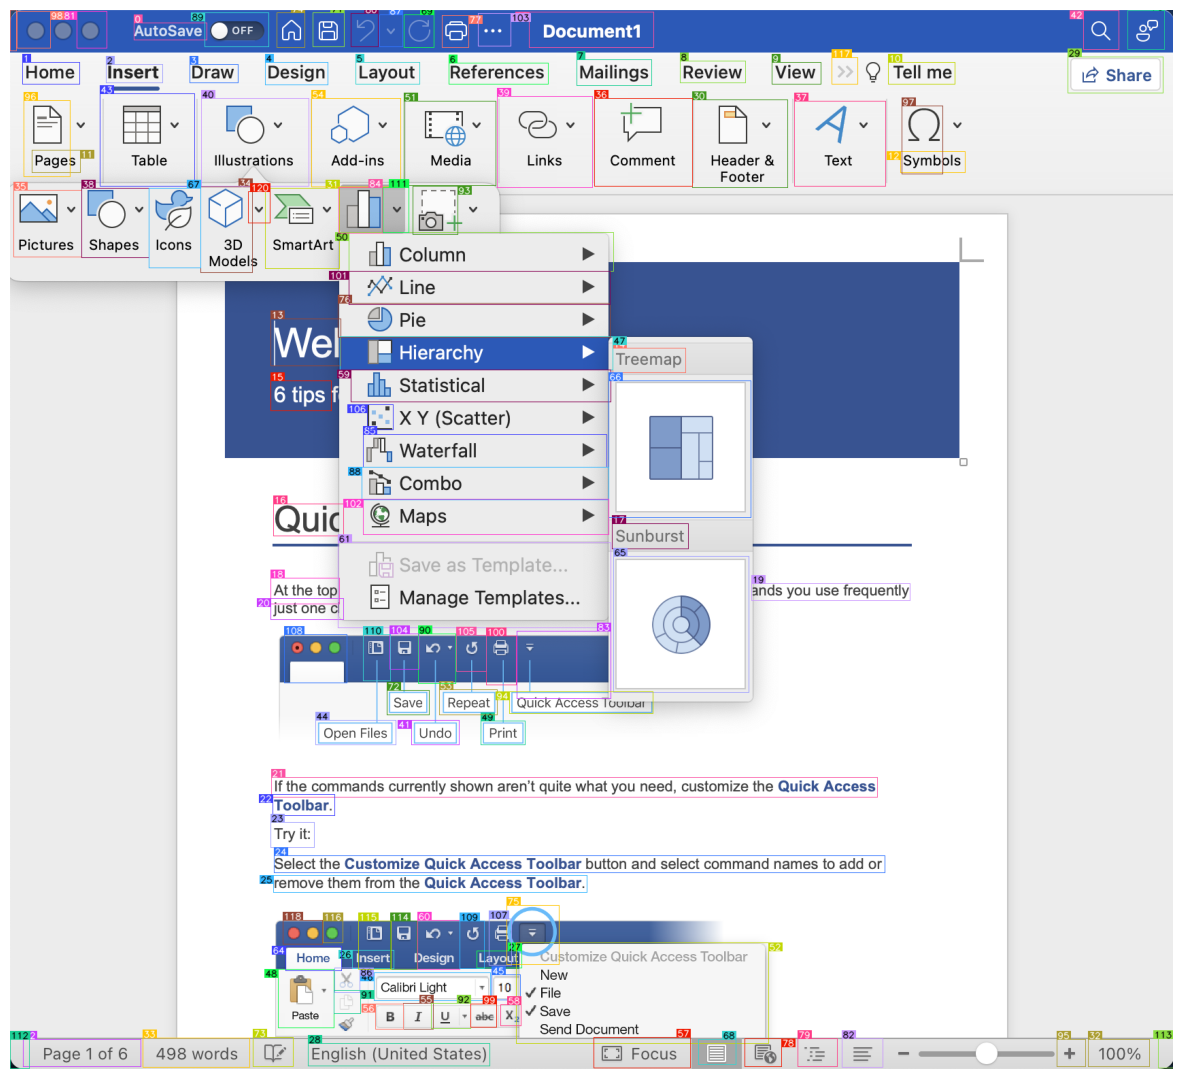

In [18]:
# plot dino_labled_img it is in base64
import base64
import matplotlib.pyplot as plt
import io
plt.figure(figsize=(15,15))

image = Image.open(io.BytesIO(base64.b64decode(dino_labled_img)))
plt.axis('off')

plt.imshow(image)
# print(len(parsed_content_list))
# plt.savefig("tmp_labeled_img", bbox_inches='tight', pad_inches=0)


In [19]:
# 增加 id 欄位到 parsed_content_list
for idx, item in enumerate(parsed_content_list, start=0):
    item['id'] = idx

print(parsed_content_list)

[{'type': 'text', 'bbox': [0.10643275082111359, 0.012836970388889313, 0.1690058410167694, 0.028883183375000954], 'interactivity': False, 'content': 'AutoSave', 'source': 'box_ocr_content_ocr', 'id': 0}, {'type': 'text', 'bbox': [0.010526316240429878, 0.05006418377161026, 0.05964912101626396, 0.07060334086418152], 'interactivity': False, 'content': 'Home', 'source': 'box_ocr_content_ocr', 'id': 1}, {'type': 'text', 'bbox': [0.08245614171028137, 0.051989730447530746, 0.13099415600299835, 0.06931964308023453], 'interactivity': False, 'content': 'Insert', 'source': 'box_ocr_content_ocr', 'id': 2}, {'type': 'text', 'bbox': [0.15438596904277802, 0.051989730447530746, 0.19590643048286438, 0.06931964308023453], 'interactivity': False, 'content': 'Draw', 'source': 'box_ocr_content_ocr', 'id': 3}, {'type': 'text', 'bbox': [0.2198830395936966, 0.050706032663583755, 0.27368420362472534, 0.07188703119754791], 'interactivity': False, 'content': 'Design', 'source': 'box_ocr_content_ocr', 'id': 4}, {'

In [7]:
import pandas as pd
df = pd.DataFrame(parsed_content_list)
df['ID'] = range(len(df))

df

,type,bbox,interactivity,content,source,ID
0,text,"[0.5770833492279053, 0.20370370149612427, 0.66...",False,Standard,box_ocr_content_ocr,0
1,text,"[0.546875, 0.4611110985279083, 0.5729166865348...",False,MC,box_ocr_content_ocr,1
2,text,"[0.6010416746139526, 0.46296295523643494, 0.62...",False,MR,box_ocr_content_ocr,2
3,text,"[0.6541666388511658, 0.46296295523643494, 0.68...",False,M+,box_ocr_content_ocr,3
4,text,"[0.7093750238418579, 0.4611110985279083, 0.735...",False,M-,box_ocr_content_ocr,4
5,text,"[0.7635416388511658, 0.4611110985279083, 0.789...",False,MS,box_ocr_content_ocr,5
6,text,"[0.8187500238418579, 0.46296295523643494, 0.84...",False,Mv,box_ocr_content_ocr,6
7,icon,"[0.6967839598655701, 0.9008353352546692, 0.778...",True,3,box_yolo_content_ocr,7
8,icon,"[0.7777496576309204, 0.9003692865371704, 0.860...",True,+,box_yolo_content_ocr,8
9,icon,"[0.614162266254425, 0.9003409147262573, 0.6970...",True,2,box_yolo_content_ocr,9


In [24]:
parsed_content_list[93]

{'type': 'icon',
 'bbox': [0.9793747663497925,
  0.008350270800292492,
  0.9978026151657104,
  0.037221141159534454],
 'interactivity': True,
 'content': 'Close',
 'source': 'box_yolo_content_yolo'}